In [1]:
from lib.data_preprocess import load_data

data_file = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"
seq_len = 256

ori_data, scalers, feature_names = load_data(
    "mytests",
    seq_len,
    file_list=[data_file],
    step=128,
    max_sequences=50000
)

print(len(ori_data), ori_data[0].shape)
print("Features:", feature_names)
print("N scalers:", len(scalers))



📌 Loading: C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat
📌 Feature order: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
📌 Total sequences: 50000 | Each: 256×7
50000 (256, 7)
Features: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
N scalers: 24


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

mat_path = r"C:\Users\Dario\Desktop\ThesiS JBP\Data\all_signals_processed.mat"

print(" ANALYSIS OF all_signals_processed.mat\n")

with h5py.File(mat_path, "r") as f:

    data_all = f["data_all"]
    n_files = data_all.shape[1]

    print(f" Total JSON files inside: {n_files}")

    signal_lengths = []
    file_lengths = []
    signal_names_global = None

    for i in range(n_files):
        ref = data_all[0][i]
        entry = f[ref]

        sig_group = entry["signals_processed"]
        sig_names = list(sig_group.keys())

        # Save signal names from first file
        if signal_names_global is None:
            signal_names_global = sig_names

        # Read one signal just to know length
        first_signal = np.array(sig_group[sig_names[0]][:]).flatten()
        file_lengths.append(len(first_signal))

        signal_lengths.append([len(np.array(sig_group[s])[:].flatten())
                               for s in sig_names])

    signal_lengths = np.array(signal_lengths)

    print("\n Signals available:", signal_names_global)
    print(" Number of signals:", len(signal_names_global))

    print("\n Length statistics per file (all signals have same length inside a file):")
    print(f"   Min length: {signal_lengths.min()}")
    print(f"   Max length: {signal_lengths.max()}")
  

    print("\n Total samples (sum of lengths):",
          int(signal_lengths[:, 0].sum()))



 ANALYSIS OF all_signals_processed.mat

 Total JSON files inside: 204

 Signals available: ['Accel1', 'Accel2', 'Accel3', 'Accel4', 'Motor_current', 'Speed', 'Temperature']
 Number of signals: 7

 Length statistics per file (all signals have same length inside a file):
   Min length: 270000
   Max length: 270000

 Total samples (sum of lengths): 55080000


In [7]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 1e-4     # LR para el generador
opt.lr_d = 5e-4    # LR para el discriminador
opt.lr_e = 1e-3     # encoder
opt.lr_r = 1e-3     # recovery
opt.lr_s = 1e-3     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 32   # muy importante
opt.num_layer = 4

opt.n_critic = 5      # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 1.0   # antes 80
opt.w_e0   = 1.0   # antes 10
opt.w_es   = 1.0   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Adjusted opt.z_dim to match data feature size: 7
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.101021
[ER] Iter 0/500 | ER Loss = 0.101021
[DEBUG] Loss this iteration: 0.066123
[DEBUG] Loss this iteration: 0.043949
[DEBUG] Loss this iteration: 0.027737
[DEBUG] Loss this iteration: 0.020657
[DEBUG] Loss this iteration: 0.015910
[DEBUG] Loss this iteration: 0.017436
[DEBUG] Loss this iteration: 0.014999
[DEBUG] Loss this iteration: 0.012766
[DEBUG] Loss this iteration: 0.014178
[DEBUG] Loss this iteration: 0.010221
[DEBUG] Loss this iteration: 0.008395
[DEBUG] Loss this iteration: 0.008508
[DEBUG] Loss this iteration: 0.007857
[DEBUG] Loss this iteration: 0.008628
[DEBUG] Loss this iteration: 0.007084
[DEBUG] Loss this iteration: 0.006113
[DEBUG] Loss this iteration: 0.004932
[DEBUG] Loss this iteration: 0.005260
[DEBUG] Loss this iteration: 0.004794
[DEBUG] Loss this iteration: 0.004318
[DEBUG] Loss this iteration: 0.004113
[DEBUG] Loss this iteration: 

🧩 Generating 50 samples in 1 batches of 64...
  ✅ Batch 1/1 generated (50 samples)


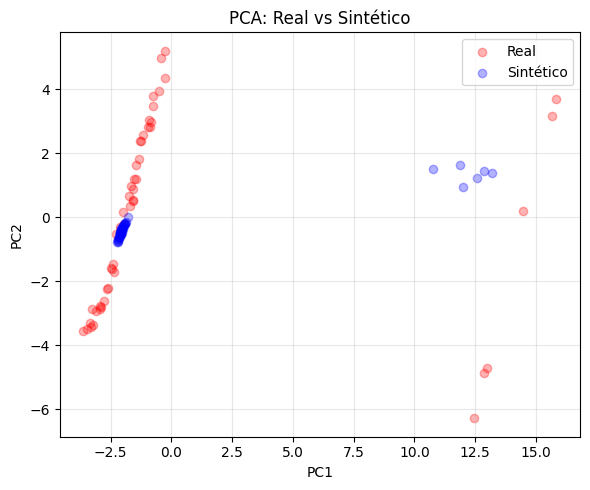

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.534282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.030140


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 500 iterations: 0.053610


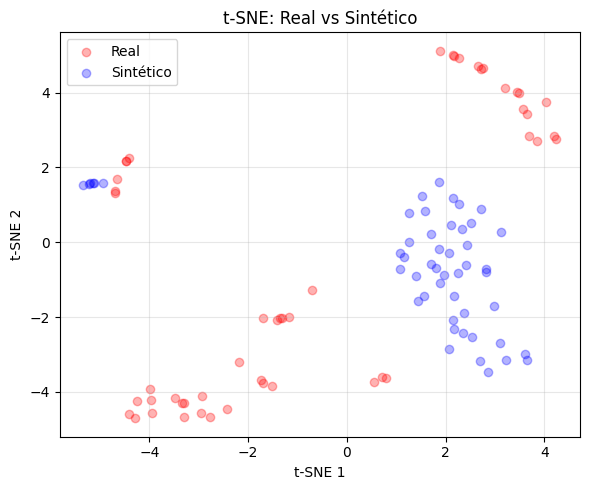

In [8]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=50, batch_size=64)

n_vis = 5000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [ ]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 5     # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 2.0   # antes 80
opt.w_e0   = 10.0   # antes 10
opt.w_es   = 1.0   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.104666
[ER] Iter 0/500 | ER Loss = 0.104666
[DEBUG] Loss this iteration: 0.088066
[DEBUG] Loss this iteration: 0.079391
[DEBUG] Loss this iteration: 0.062557
[DEBUG] Loss this iteration: 0.055545
[DEBUG] Loss this iteration: 0.051269
[DEBUG] Loss this iteration: 0.043463
[DEBUG] Loss this iteration: 0.044311
[DEBUG] Loss this iteration: 0.039465
[DEBUG] Loss this iteration: 0.035182
[DEBUG] Loss this iteration: 0.035176
[DEBUG] Loss this iteration: 0.036080
[DEBUG] Loss this iteration: 0.033907
[DEBUG] Loss this iteration: 0.031918
[DEBUG] Loss this iteration: 0.031632
[DEBUG] Loss this iteration: 0.029542
[DEBUG] Loss this iteration: 0.029894
[DEBUG] Loss this iteration: 0.026334
[DEBUG] Loss this iteration: 0.028177
[DEBUG] Loss this iteration: 0.024889
[DEBUG] Loss this iteration: 0.023683
[DEBUG] Loss this iteration: 0.024857
[DEBUG] Loss this iteration: 0.023

🧩 Generating 50000 samples in 782 batches of 64...
  ✅ Batch 1/782 generated (64 samples)
  ✅ Batch 2/782 generated (64 samples)
  ✅ Batch 3/782 generated (64 samples)
  ✅ Batch 4/782 generated (64 samples)
  ✅ Batch 5/782 generated (64 samples)
  ✅ Batch 6/782 generated (64 samples)
  ✅ Batch 7/782 generated (64 samples)
  ✅ Batch 8/782 generated (64 samples)
  ✅ Batch 9/782 generated (64 samples)
  ✅ Batch 10/782 generated (64 samples)
  ✅ Batch 11/782 generated (64 samples)
  ✅ Batch 12/782 generated (64 samples)
  ✅ Batch 13/782 generated (64 samples)
  ✅ Batch 14/782 generated (64 samples)
  ✅ Batch 15/782 generated (64 samples)
  ✅ Batch 16/782 generated (64 samples)
  ✅ Batch 17/782 generated (64 samples)
  ✅ Batch 18/782 generated (64 samples)
  ✅ Batch 19/782 generated (64 samples)
  ✅ Batch 20/782 generated (64 samples)
  ✅ Batch 21/782 generated (64 samples)
  ✅ Batch 22/782 generated (64 samples)
  ✅ Batch 23/782 generated (64 samples)
  ✅ Batch 24/782 generated (64 samples

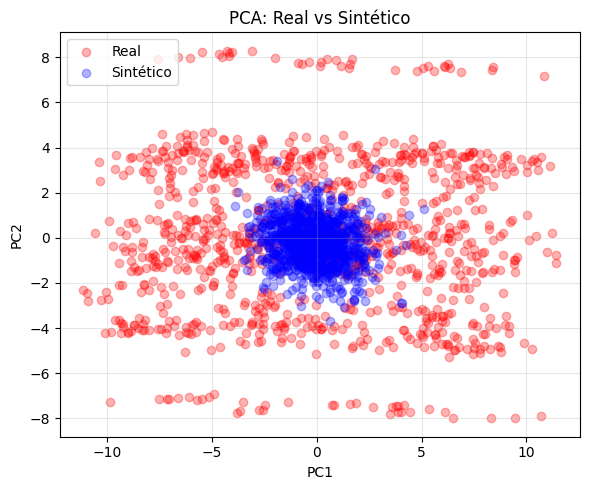

🌀 Ejecutando t-SNE (puede tardar unos segundos)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.278545


c:\Users\Dario\Desktop\ThesiS JBP\jordan_venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.169937
[t-SNE] KL divergence after 500 iterations: 1.967948


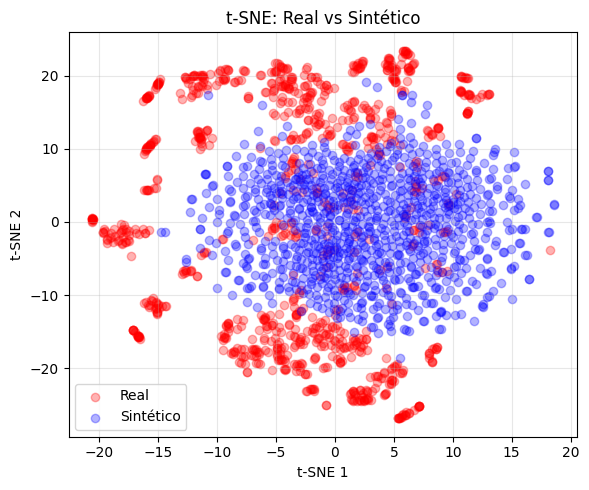

In [30]:
from generation_TGAN import safe_generation
import numpy as np

generated_data = safe_generation(model, num_samples=len(ori_data), batch_size=64)

n_vis = 50000  # target

n_real = min(n_vis, len(ori_data))
n_fake = min(n_vis, len(generated_data))

idx_real = np.random.choice(len(ori_data), n_real, replace=False)
idx_fake = np.random.choice(len(generated_data), n_fake, replace=False)

ori_vis = [ori_data[i] for i in idx_real]
gen_vis = [generated_data[i] for i in idx_fake]

from visualization_TGAN import visualization

visualization(ori_vis, gen_vis, 'pca')
visualization(ori_vis, gen_vis, 'tsne')

In [31]:
import numpy as np

syn_data = np.array(generated_data)   # datos sintéticos
real_data = np.array(ori_data)        # datos reales

# Aplanar correctamente: (N, seq_len, features)
# Calculamos medias y std por feature
real_mean = real_data.mean(axis=(0,1))
real_std  = real_data.std(axis=(0,1))

syn_mean  = syn_data.mean(axis=(0,1))
syn_std   = syn_data.std(axis=(0,1))

print("==== MEDIA POR FEATURE ====")
for i in range(len(real_mean)):
    print(f"Feature {i}: Real = {real_mean[i]:.4f}, Synthetic = {syn_mean[i]:.4f}")

print("\n==== STD POR FEATURE ====")
for i in range(len(real_std)):
    print(f"Feature {i}: Real = {real_std[i]:.4f}, Synthetic = {syn_std[i]:.4f}")


==== MEDIA POR FEATURE ====
Feature 0: Real = 0.5047, Synthetic = 0.5004
Feature 1: Real = 0.4585, Synthetic = 0.4532
Feature 2: Real = 0.4708, Synthetic = 0.4627
Feature 3: Real = 0.4982, Synthetic = 0.4953
Feature 4: Real = 0.5024, Synthetic = 0.4856
Feature 5: Real = 0.5642, Synthetic = 0.5555
Feature 6: Real = 0.4427, Synthetic = 0.4196

==== STD POR FEATURE ====
Feature 0: Real = 0.2008, Synthetic = 0.1991
Feature 1: Real = 0.1775, Synthetic = 0.1675
Feature 2: Real = 0.1453, Synthetic = 0.1422
Feature 3: Real = 0.2195, Synthetic = 0.2129
Feature 4: Real = 0.1735, Synthetic = 0.1676
Feature 5: Real = 0.1822, Synthetic = 0.1767
Feature 6: Real = 0.2921, Synthetic = 0.2793


In [ ]:

from options_TGAN import Options
from lib.TimeGAN import TimeGAN

# 1. Options
opt = Options().parse()


opt.print_freq = 100    # imprime cada iteración

# 2. Set paper-style hyperparameters
opt.lr_g = 5e-5     # LR para el generador
opt.lr_d = 1e-4    # LR para el discriminador
opt.lr_e = 1e-4     # encoder
opt.lr_r = 5e-4     # recovery
opt.lr_s = 2e-4     # supervisor


opt.beta1 = 0.5

opt.batch_size = 64
opt.iteration = 500

opt.hidden_dim = 48   # muy importante
opt.num_layer = 2

opt.n_critic = 7     # OK
opt.gp_lambda = 10   # OK
opt.name = "TimeGAN_real_paper_settings"

opt.w_g    = 2.0   # antes 80
opt.w_e0   = 10.0   # antes 10
opt.w_es   = 0.5   # antes 0.1, lo dejamos en la misma escala
opt.w_gamma = 1.0  # este se puede mantener


# 3. Create model
model = TimeGAN(opt, ori_data)

# 4. Train
model.train()


[INFO] Auto-set z_dim = 7 (feature size from data)
=== PRETRAINING: Embedding + Recovery ===
[DEBUG] Loss this iteration: 0.121422
[ER] Iter 0/500 | ER Loss = 0.121422
[DEBUG] Loss this iteration: 0.107588
[DEBUG] Loss this iteration: 0.088950
[DEBUG] Loss this iteration: 0.073979
[DEBUG] Loss this iteration: 0.066281
[DEBUG] Loss this iteration: 0.052892
[DEBUG] Loss this iteration: 0.045634
[DEBUG] Loss this iteration: 0.041559
[DEBUG] Loss this iteration: 0.040964
[DEBUG] Loss this iteration: 0.036124
[DEBUG] Loss this iteration: 0.033920
[DEBUG] Loss this iteration: 0.033801
[DEBUG] Loss this iteration: 0.030165
[DEBUG] Loss this iteration: 0.031211
[DEBUG] Loss this iteration: 0.030289
[DEBUG] Loss this iteration: 0.027566
[DEBUG] Loss this iteration: 0.026299
[DEBUG] Loss this iteration: 0.025036
[DEBUG] Loss this iteration: 0.025483
[DEBUG] Loss this iteration: 0.024425
[DEBUG] Loss this iteration: 0.022381
[DEBUG] Loss this iteration: 0.021014
[DEBUG] Loss this iteration: 0.021